# Random Forest! :D

### Preprocessing data

In [1]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

from sklearn import preprocessing

In [2]:
rater_df = pd.read_csv("JokeRater.csv")
rating_df = pd.read_csv("JokeRating.csv")
joke_df = pd.read_csv("Joke.csv")

Looking at the CSVs.

In [3]:
rater_df.rename(columns = {'id':'joke_rater_id'}, inplace = True)
joke_df.rename(columns = {'id':'joke_id'}, inplace = True)
joke_df['joke_id'] = joke_df['joke_id'].astype(float)
rater_df = rater_df.drop('joke_submitter_id', axis=1)
joke_df = joke_df.drop('joke_submitter_id', axis=1)
joke_df = joke_df.drop('joke_source', axis=1)

Joining databases together all into one. M E R G E T I M E

In [4]:
df = pd.merge(rating_df, rater_df, on="joke_rater_id", how="outer")
df = df.drop('id', axis=1)

df = pd.merge(df, joke_df, on='joke_id', how='outer')

#### Deal with NA's.

In [5]:
which_drop = df[df.isnull().sum(axis=1) > 2].index
new_df = df.drop(which_drop)
#new_df.isnull().sum()

Replace NaN categories by Mode.

In [7]:
modes = new_df.mode()
new_df.birth_country = new_df.birth_country.fillna("United States")
new_df.preferred_joke_type = new_df.preferred_joke_type.fillna("Puns")
new_df.preferred_joke_genre2 = new_df.preferred_joke_genre.fillna("Programming")

Joke subject should be taken care of from the Features team.

Found that Joke Type is null for the same joke. Remove those jokes.

In [8]:
new_df = new_df.drop(new_df[new_df.joke_type.isnull() == True].index)
new_df.subject = new_df.subject.fillna('0')

In [9]:
string_col = [3, 5, 6, 7, 8, 9, 10, 11, 12, 13]
#new_df.iloc[:,string_col] = pd.get_dummies(new_df.iloc[:,string_col])

In [12]:
not_string = []
for i in range(16):
    if i not in string_col:
        not_string.append(i)

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=(8*6 + 3))
X = pd.get_dummies(new_df.iloc[:,string_col])
pca.fit(X)
ar = pca.explained_variance_ratio_
print(np.cumsum(ar))
reduced_dummies = pca.fit_transform(X) # reduced from 106 to 51

[ 0.08986781  0.1584369   0.21157426  0.25837188  0.30193919  0.33922195
  0.37267296  0.40251342  0.43195977  0.46009321  0.48806599  0.51481771
  0.54011393  0.56252919  0.58492521  0.60553063  0.62557478  0.64527834
  0.66358454  0.68155917  0.69811678  0.71407773  0.7296272   0.74471626
  0.75884309  0.77198278  0.783481    0.79476465  0.80555229  0.81563274
  0.82534605  0.83436365  0.84319436  0.85161735  0.85937115  0.86693662
  0.87416525  0.88116392  0.88812203  0.89500603  0.90140274  0.90746124
  0.91320365  0.91874225  0.92405665  0.92884941  0.93345705  0.93796265
  0.94217198  0.94622114  0.95018393]


In [42]:
temp = new_df.iloc[:,not_string].reset_index(drop=True)
df3 = pd.concat([temp, pd.DataFrame(reduced_dummies)], axis=1)

### Random Forest implementation

In [44]:
y = df3.rating
Y_list = list(y.values)
cols = [i for j in (range(3, 4), range(6, df3.shape[1]-1)) for i in j] # excluding text, subject, and ID's
features = df3.columns[cols]

rf = RandomForestRegressor()
rf.fit(df3[features], y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [46]:
# predicting on the SAME data, just to test it out
rf.predict(df3[features]).astype('float')

array([ 5.        ,  4.2875    ,  2.64666667, ...,  2.78      ,
        2.05489177,  3.58166667])

In [47]:
def mse(predicted, real):
    real = np.array(real)
    predicted = np.array(predicted)
    temp =  (real - predicted) * (real - predicted)
    mse = 0.5 * sum(temp)
    return mse

In [48]:
mse(y, rf.predict(df3[features]).astype('float'))

4787.0988641100166

Time to do some training and testing split.

In [50]:
import sklearn.model_selection

X = df3[features]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.30, random_state=42)

<b>Regression on the Training/Test data</b>

In [52]:
rf2 = RandomForestRegressor(n_estimators=50, max_features='sqrt', random_state=42, max_depth=15)
rf2.fit(X_train, list(y_train))

rf2.predict(X_test).astype('float')
mse(y_test, rf2.predict(X_test).astype('float'))

2808.7499759330831

In [59]:
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
ax = sns.regplot(x=y_test, y=rf2.predict(X_test).astype('float'), scatter_kws={'alpha':0.1})
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted Rating vs. Actual Rating")
plt.show()

C:\Users\Cindy\Anaconda3\lib\site-packages\matplotlib\lines.py:44: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if is_string_like(style) and is_hashable(style):
C:\Users\Cindy\Anaconda3\lib\site-packages\matplotlib\font_manager.py:971: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if is_string_like(family):
C:\Users\Cindy\Anaconda3\lib\site-packages\matplotlib\font_manager.py:697: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if is_string_like(family):
C:\Users\Cindy\Anaconda3\lib\site-packages\matplotlib\text.py:218: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  elif is_string_like(fontproperties):


AttributeError: module 'matplotlib.cbook' has no attribute 'popall'

In [60]:
# see what factors are most important
s = pd.DataFrame((rf2.feature_importances_))

In [61]:
s = s.transpose()
s.columns = features
s = s.transpose()

In [62]:
s.sort_values(by=0, ascending=False) # lots of programming jokes and people who liked programming

,0
1,0.037527
30,0.033342
45,0.031792
17,0.030069
39,0.029567
18,0.029366
28,0.028033
4,0.027980
12,0.027742
15,0.025928


2666.25834457


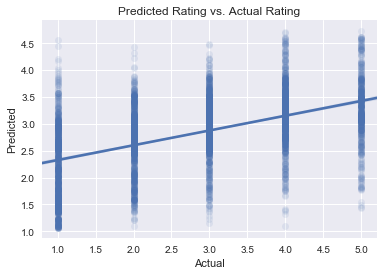

In [124]:
# using label encoding instead -- is not technically right since there's correlation between numerical encoding and regression
y = new_df.rating
Y_list = list(y.values)
cols = range(3, 14) # excluding text, subject, and ID's
features = new_df.columns[cols]

X = new_df[features]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.30, random_state=42)

rf3 = RandomForestRegressor(n_estimators=50, max_features='auto', random_state=42, max_depth=10)
rf3.fit(X_train, list(y_train))

rf3.predict(X_test).astype('float')
print(mse(y_test, rf3.predict(X_test).astype('float')))
ax2 = sns.regplot(x=y_test, y=rf3.predict(X_test).astype('float'), scatter_kws={'alpha':0.1})
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted Rating vs. Actual Rating")
plt.show()